### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

#### Read in data

In [2]:
## User defined options
# not looking at TWS, instead of surface water content.

var  = ['GPP','TBOT', 'TWS']#'SOILWATER_10CM']
suff = '/lnd/proc/tseries/month_1/'

# TODO, this is a pretty inefficient way to look at multiple simulations / models
#       but until the SVD calculation is faster it may not be worth trying to look at multiple models at once
#       JH, suggestions here would also be welcome.
## For Keith's CLM5 GSWP3 simulations
model =('CLM5_GSWP3', 'CLM45_GSWP3')
case = ('clm50_r270_1deg_GSWP3V1_iso_newpopd_hist',
         'clm45_r270_1deg_GSWP3V1_hist')
path = ('/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/'+case[0]+suff,
        '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/'+case[1]+suff)

## For Keith's CLM4.5 GSWP3 simulations
#model = 'CLM45_GSWP3'
#case = 'clm45_r270_1deg_GSWP3V1_hist'
#path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/'+case+suff

file0 = path[0] + case[0] +'.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path[0] + case[0] +'.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path[0] + case[0] +'.clm2.h0.'+ var[2] +'.185001-201412.nc'

file0B = path[1] + case[1] +'.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1B = path[1] + case[1] +'.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2B = path[1] + case[1] +'.clm2.h0.'+ var[2] +'.185001-201412.nc'

## For Danica's no crop run
#model = 'CLM5_GSWP3 _noCrop'
#path = '/glade/p/cesm/lmwg_dev/dll/CLM5GSWP3_NoCrop/SingleVarTimeFiles/'
#file0 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[0] +'.185001-201012.nc'
#file1 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[1] +'.185001-201012.nc'
#file2 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[2] +'.185001-201012.nc'
print(file0)
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
# ?? TODO, is there a more efficient way of reading in multiple variables into a signle dataset??
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time')
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')

ds0B   = utils.time_set_mid(xr.open_dataset(file0B, decode_times=True), 'time')
ds1B   = utils.time_set_mid(xr.open_dataset(file1B, decode_times=True), 'time')
ds2B   = utils.time_set_mid(xr.open_dataset(file2B, decode_times=True), 'time')
ds = xr.merge([ds0, ds1, ds2])
dsB = xr.merge([ds0B, ds1B, ds2B])

# it would be nice to get these into a single dataset, with an extra 'model' dimension
# Mask out data where TBOT < 0, as in Zach's paper
# ds[var[0]] = ds[var[0]].where(ds[var[1]] < 273.15)
# ds[var[2]] = ds[var[2]].where(ds[var[1]] < 273.15)
# ds[var[1]] = ds[var[1]].where(ds[var[1]] < 273.15)


area = ds0.area
landfrac = ds0.landfrac
print(ds)

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc
<xarray.Dataset>
Dimensions:       (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat           (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.25 357.5 358.75
  * time          (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: hist_interval
Data variables:
    BSW           (levgrnd, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZLAKE        (levlak, lat, lon) float32 nan nan nan nan ... 

## --- This is example code to make sure things are working ---
###          Quick look at annual cycle for a grid cell

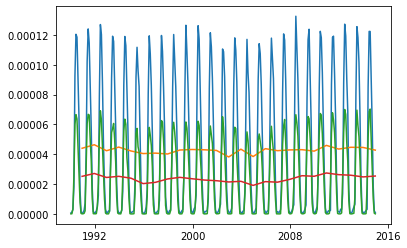

In [3]:
years = 25
months = years * 12
tlat =  60  #-3
tlon =  240 #280
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

dsB_test = dsB.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
dsB_last = dsB_test.isel(time=slice(-months,None))
datasetB = dsB_last.get(var)
dsB_ann  = datasetB.apply(utils.weighted_annual_mean)
plt.plot(dsB_last.time['time'], dsB_last.get(var[0]), '-' );
plt.plot(dsB_ann.time['time'], dsB_ann.get(var[0]), '-' );


### Calculate climatology and anomalies

In [4]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = ds_anom.get(var).map(signal.detrend)   # still need to use get so detrend works
# resample monthly data to seasonal
ds_detrend_season = ds_detrend.resample(time="QS-DEC").mean()
print(ds_detrend_season)

dsB_climo = esmlab.core.climatology(dsB_last,freq='mon')
dsB_anom = esmlab.core.anomaly(dsB_last, clim_freq='mon', time_coord_name='time')
dsB_detrend = dsB_anom.get(var).map(signal.detrend)   # still need to use get so detrend works
dsB_detrend_season = dsB_detrend.resample(time="QS-DEC").mean()


<xarray.Dataset>
Dimensions:  (time: 101)
Coordinates:
  * time     (time) object 1989-12-01 00:00:00 ... 2014-12-01 00:00:00
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    GPP      (time) float32 -1.5104122e-07 3.2355529e-06 ... -2.9195567e-07
    TBOT     (time) float32 -4.2782845 2.0979266 ... -0.9601051 0.532446
    TWS      (time) float32 159.25223 146.23299 ... 104.112434 114.63586
Attributes:
    history:  \n2020-01-30 05:06:46.936369 esmlab.anomaly(<DATASET>, clim_fre...


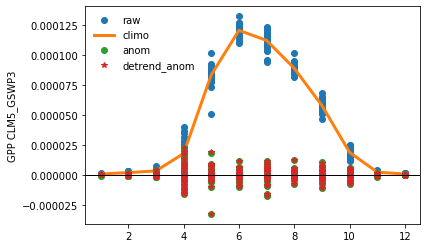

In [5]:
# JH doesn't like using generic variables here, but 
# I'm going leave this for now, because the analysis may not always focus on GPP.
plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[0]), '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0]+" "+model[0]);

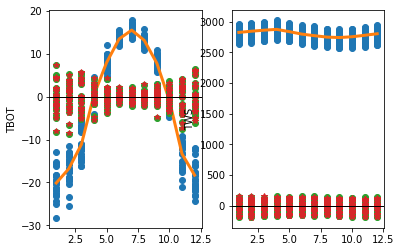

In [6]:
# now look at temp and soil moisture anomalies
plt.subplot(1, 2, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1])-273.15, 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1])-273.15, '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[1]), '*' );
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 2, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[2]), '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2]);

#### Seaonal GPP anomalies seem to show a similar pattern to TWS in CLM4.5 
#### Stonger temperature sensitivity w/ CLM5?

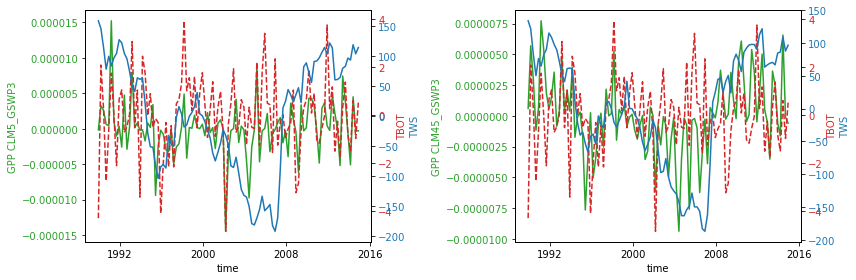

In [7]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)

color = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel(var[0]+" "+model[0], color=color)
ax1.plot(ds_detrend_season.time, ds_detrend_season.get(var[0]), '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel(var[1], color=color)  # we already handled the x-label with ax1
ax2.plot(ds_detrend_season.time, ds_detrend_season.get(var[1]), '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel(var[2], color=color)  # we already handled the x-label with ax1
ax3.plot(ds_detrend_season.time, ds_detrend_season.get(var[2]), '-', color=color)
ax3.tick_params(axis='y', labelcolor=color)

# repeat plot for CLM4.5
ax4 = fig.add_subplot(1,2,2)
color = 'tab:green'
ax4.set_xlabel('time')
ax4.set_ylabel(var[0]+" "+model[1], color=color)
ax4.plot(dsB_detrend_season.time, dsB_detrend_season.get(var[0]), '-', color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax5.set_ylabel(var[1], color=color)  # we already handled the x-label with ax1
ax5.plot(dsB_detrend_season.time, dsB_detrend_season.get(var[1]), '--', color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax4.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax6.set_ylabel(var[2], color=color)  # we already handled the x-label with ax1
ax6.plot(dsB_detrend_season.time, dsB_detrend_season.get(var[2]), '-', color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show();



 ### Do we need to detrend data?

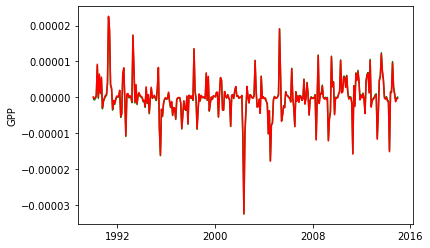

In [8]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend.get(var[0]), '-' ,c='red')
plt.ylabel(var[0]);

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

(12, 25)


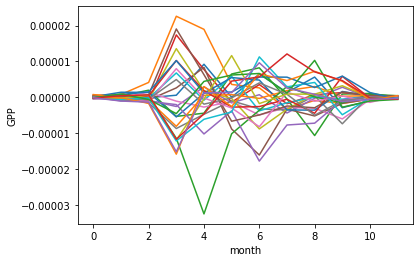

In [9]:
# orig. mon x year
iavmatrix_0 =np.zeros([12, years])
iavmatrix_1 =np.zeros([12, years])
iavmatrix_2 =np.zeros([12, years])
for iyr in range(years):
    iavmatrix_0[0:12, iyr]=ds_detrend.get(var[0])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_1[0:12, iyr]=ds_detrend.get(var[1])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_2[0:12, iyr]=ds_detrend.get(var[2])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

print(iavmatrix_0.shape)

plt.figure();
plt.plot(iavmatrix_0) #this plots months on x-axis, 1 line/year
plt.ylabel(var[0])
plt.xlabel('month');

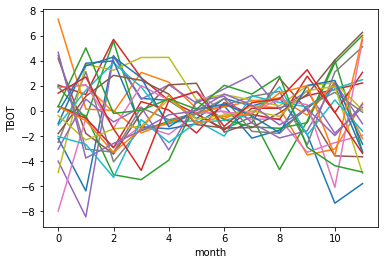

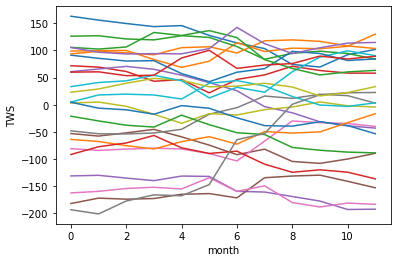

In [10]:
plt.figure();
plt.plot(iavmatrix_1) #this plots months on x-axis, 1 line/year
plt.ylabel(var[1])
plt.xlabel('month');

plt.figure();
plt.plot(iavmatrix_2) #this plots months on x-axis, 1 line/year
plt.ylabel(var[2])
plt.xlabel('month');
# GKA noticed high wintertime variability at this site, that we typically don't think about!

### Now try using SVD_tools.py
This code was provided by Gretchen Keppel-Aleks & initially developed by Zach Butterfield

Further modified by W. Wieder to accept matrix when years > 12 (nmonths)
- Decompose function accepts a month * year matrix and calculates vectors (dimensions = years,months) and weights (years,years)  
- Redistribution function takes vectors, weights, and matrix to calculate theta (years), & varfrac (years)

In [11]:
import SVD_tools as svd
#assign the 2-D matrix (month x year) to decompose
vectors, weights=svd.decompose(iavmatrix_0) #Call the function to calculate the singular vectors and their annual weights
vectors1, weights1=svd.decompose(iavmatrix_1) 
vectors2, weights2=svd.decompose(iavmatrix_2) 

theta ,varfrac =svd.calc_redistribution(vectors , weights , iavmatrix_0)
theta1,varfrac1=svd.calc_redistribution(vectors1, weights1, iavmatrix_1)
theta2,varfrac2=svd.calc_redistribution(vectors2, weights2, iavmatrix_2)

print(vectors.shape)  #(nyears , nmonths)
print(weights.shape)
print(ds_detrend_season) #(101 time slices, needs to be reshaped to nyears*season)

(25, 12)
(25, 25)
<xarray.Dataset>
Dimensions:  (time: 101)
Coordinates:
  * time     (time) object 1989-12-01 00:00:00 ... 2014-12-01 00:00:00
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    GPP      (time) float32 -1.5104122e-07 3.2355529e-06 ... -2.9195567e-07
    TBOT     (time) float32 -4.2782845 2.0979266 ... -0.9601051 0.532446
    TWS      (time) float32 159.25223 146.23299 ... 104.112434 114.63586
Attributes:
    history:  \n2020-01-30 05:06:46.936369 esmlab.anomaly(<DATASET>, clim_fre...


/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


In [12]:
# also try spearman's rank correlation
from scipy.stats import spearmanr
mm2plot=ds_climo.get(var[0])
corr0, _ = spearmanr(mm2plot,vectors[0,:])
corr1, _ = spearmanr(mm2plot,vectors[1,:])
print('Spearmans correlation SV1-Climo: %.3f' % corr0)
print('Spearmans correlation SV2-Climo: %.3f' % corr1)

# also try weighting correlation based on monthly contribution to annual flux
wgt = mm2plot/mm2plot.sum()

# code bit below is identical to np.average
#def m(x, w):
#    """Weighted Mean"""
#    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))
r1 = corr(mm2plot.values,vectors[0,:], wgt.values)
r2 = corr(mm2plot.values,vectors[1,:], wgt.values)


#temp = m(mm2plot.values, wgt.values)
#print(m)
print('weighted correlation SV1-Climo: %.3f' % r1)
print('weighted correlation SV2-Climo: %.3f' % r2)
if (r1<0):
    vectors[0,:] = -vectors[0,:]

Spearmans correlation SV1-Climo: 0.399
Spearmans correlation SV2-Climo: -0.804
weighted correlation SV1-Climo: 0.401
weighted correlation SV2-Climo: -0.571


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


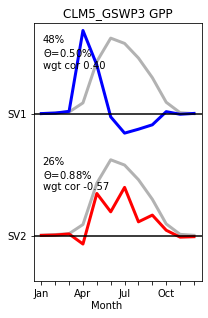

In [13]:
# Plot First and Second Singular Vectors
# TODO This is a pretty complicated plotting method that could likely be improved & made into a function
# That said, the it makes nice, clear plots... we'll keep it for now

fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
vectors2plot=vectors*7000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.50,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0])+
        "%\n"+str('wgt cor %.2f' % r1))
ax1.text(0.5,.10,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1])+
        "%\n"+str('wgt cor %.2f' % r2))

#ax1.text(0.5,.55,str('rank cor %.2f' % corr0))
#ax1.text(0.5,.15,str('rank cor %.2f' % corr1))

ax1.title.set_text(model[0] +' '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_'+model[0]+'_ex_GPP.eps') ;


In [14]:
print(r1)
# Can correlations between climatology and Vectors tell us someting about the nature of relationships?
# In this example SV2 shows higher correlation with climatology of GPP
x  = xr.DataArray(data=mm2plot)
y0 = xr.DataArray(data=vectors[0,:])
y1 = xr.DataArray(data=vectors[1,:])
temp = esmlab.statistics.weighted_corr(x,y1)
print(temp)
cor1 = np.corrcoef(mm2plot,vectors[0,:])
cor2 = np.corrcoef(mm2plot,vectors[1,:])
print(cor1 )
print('..')
print(cor2)

0.40061745637098467
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    r        float64 -5.836e-18
    p        float64 1.0
[[1.         0.17786995]
 [0.17786995 1.        ]]
..
[[ 1.         -0.84945569]
 [-0.84945569  1.        ]]


### How do weights from SV coorelate with seasonal climate anomalies?

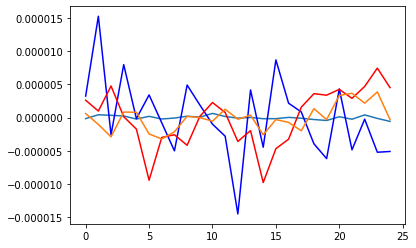

In [15]:
# TODO, there must be a better way to reshape data, but I can't get group by to work
season_group = ds_detrend_season.groupby('time.year')
#print(ds_detrend_season.GPP[0:5])
#print(ds_detrend_season.time[0:5])

#reshape timeseries vector into a matrix (season x year)
# Omits the last year, which only has data for Dec
group_0 =np.zeros([4, years])
group_1 =np.zeros([4, years])
group_2 =np.zeros([4, years])


for iyr in range(years):
    group_0[0:4,iyr]=ds_detrend_season.get(var[0])[(iyr*4):(iyr*4)+4] #reshape timeseries vector into a matrix (season x year) 
    group_1[0:4,iyr]=ds_detrend_season.get(var[1])[(iyr*4):(iyr*4)+4] #reshape timeseries vector into a matrix (year x month) 
    group_2[0:4,iyr]=ds_detrend_season.get(var[2])[(iyr*4):(iyr*4)+4] #reshape timeseries vector into a matrix (year x month) 

#print(group_0[:,0])

# Plot seasonal anomalies by year
plt.plot(group_0[0,], '-' )
plt.plot(group_0[1,], '-',color='blue' ) #MAM
plt.plot(group_0[2,], '-',color='red' )  #JJA
plt.plot(group_0[3,], '-' );

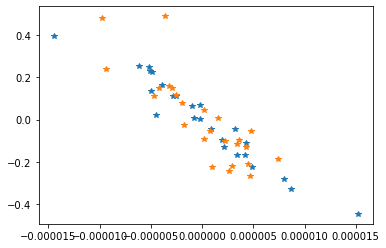

In [16]:
# in this gridcell, 
# weights for SV1 of GPP = the inverse as MAM GPP anomalies 
# weights for SV2 of GPP = the inverse as JJA GPP anomalies 
plt.plot(group_0[1,:],weights[0,:], '*' )
plt.plot(group_0[2,:],weights[1,:], '*' );

In [17]:
# phase shift (SV1),  coorelated with MAM TBOT anomalies
# amplification (SV2),  coorelated with JJA TWS anomalies
# this pattern of phase ~ TBOT & AMP ~ TWS holds for CLM4.5 too
r0a = corr(weights[0,:],group_1[1,:],np.ones(years))
r1a = corr(weights[0,:],group_2[1,:],np.ones(years))
r0b = corr(weights[0,:],group_1[2,:],np.ones(years))
r1b = corr(weights[0,:],group_2[2,:],np.ones(years))

r2a = corr(weights[1,:],group_1[1,:],np.ones(years))
r3a = corr(weights[1,:],group_2[1,:],np.ones(years))
r2b = corr(weights[1,:],group_1[2,:],np.ones(years))
r3b = corr(weights[1,:],group_2[2,:],np.ones(years))

print(var[0]+' SV_1, '+var[1]+' MAM anom. : %.3f' % r0a)
print(var[0]+' SV_1, '+var[2]+' MAM anom. : %.3f' % r1a)
print(var[0]+' SV_1, '+var[1]+' JJA anom. : %.3f' % r0b)
print(var[0]+' SV_1, '+var[2]+' JJA anom. : %.3f' % r1b)
print()
print(var[0]+' SV_2, '+var[1]+' MAM anom. : %.3f' % r2a)
print(var[0]+' SV_2, '+var[2]+' MAM anom. : %.3f' % r3a)
print(var[0]+' SV_2, '+var[1]+' JJA anom. : %.3f' % r2b)
print(var[0]+' SV_2, '+var[2]+' JJA anom. : %.3f' % r3b)


GPP SV_1, TBOT MAM anom. : -0.746
GPP SV_1, TWS MAM anom. : 0.230
GPP SV_1, TBOT JJA anom. : 0.056
GPP SV_1, TWS JJA anom. : 0.245

GPP SV_2, TBOT MAM anom. : -0.302
GPP SV_2, TWS MAM anom. : -0.703
GPP SV_2, TBOT JJA anom. : -0.080
GPP SV_2, TWS JJA anom. : -0.770


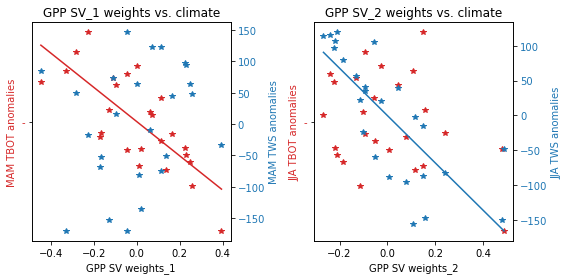

In [18]:
# -- plot SV_1, w/ regression for JJA TBOT anomalies --
x = weights[0,:]
y = group_1[1,:]
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(1,2,1)
color = 'tab:red'
ax1.set_xlabel(var[0]+' SV weights_1')
ax1.set_ylabel('MAM '+var[1]+' anomalies', color=color)
ax1.plot(x, y,'*', '-', color=color)
ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text(var[0]+' SV_1 weights vs. climate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MAM '+var[2]+' anomalies', color=color)
ax2.plot(x, group_2[1,:],'*' , color=color)
ax2.tick_params(axis='y', labelcolor=color)

# --- now sv_2, w/ regression for TWS
ax3 = fig.add_subplot(1,2,2)
x = weights[1,:]
y = group_2[2,:]
color = 'tab:red'
ax3.set_xlabel(var[0]+' SV weights_2')
ax3.set_ylabel('JJA '+var[1]+' anomalies', color=color)
ax3.plot(x, group_1[1,:],'*', '-', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.title.set_text(var[0]+' SV_2 weights vs. climate')

ax4 = ax3.twinx()  
color = 'tab:blue'
ax4.set_ylabel('JJA '+var[2]+' anomalies', color=color)
ax4.plot(x, y,'*' , color=color)
ax4.tick_params(axis='y', labelcolor=color)
ax4.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
fig.tight_layout();

### TODO, in the global code we'll need to: 
* Determine how weights correspond with GPP anomalies (+ or -)
* Loop over seasonal anomalies & determine correlation coefficients w/ SV_1 & 2
## --- End of example code  ---

## Calculate global anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


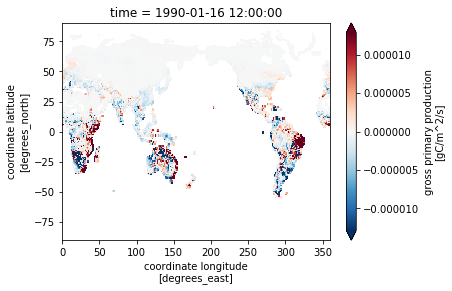

In [19]:
# Use esmlab to calculate climatology & anomalies

# TODO, refer to variables by name (e.g. anom_gpp) to improve readability
# Will leave this for now to have a more generalizable code

ds2 = ds.isel(time=slice(-months,None))             # Select last N years of data
ds_climo = esmlab.core.climatology(ds2,freq='mon')  # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
anom_0   = ds_anom.get(var[0])                   # returns a xr.DataArray with dims (time,lat,lon)
anom_0   = anom_0.where(anom_0.max(dim='time') )
anom_0.isel(time=0).plot(robust=True);

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac
- We dont' need the SV for TBOT and TWS, but we do need seasonal means of detrended anomalies 

In [20]:
# define function to cacluate svd vectors, weights, etc.
# First we have to detrend the data
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (months x year) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

# define function to generate  seasonal means & reshape to season x year
# reads in full dataset & returns all variables
# returns a np.array dimensioned [var, season, year]
def seasonal_wrap(anom, var=var, years=years):
    if np.isnan(anom.get(var[0]))[0] == False:
        # detrend data
        detrend = anom.get(var).map(signal.detrend)  
        
        # resample monthly data to seasonal
        detrend_season = detrend.resample(time="QS-DEC").mean()
        
        # reshape timeseries vector into a matrix (var, season, year) 
        nvars = len(var)
        seasonal=np.zeros([nvars, 4, years])

        for nv in range(nvars):
            for iyr in range(years):
                seasonal[nv, 0:4, iyr]=detrend_season.get(var[nv])[iyr*4:(iyr+1)*4] 
            
    return seasonal               

In [114]:
## Select a single grid point to work with first
ds_temp = ds_anom.sel(lat=tlat, lon=tlon, method='nearest') 
season_wrap = seasonal_wrap(ds_temp, var, years)
print(season_wrap)
## Make sure wrapper results are the same as above
#[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
#plt.plot(theta_wrap - theta, '*') ;
#plt.plot(varfrac_wrap - varfrac, '*',c='r') ;
#print ('differences between results look prety small')

[[[-1.51040425e-07  4.29392600e-07  3.46512564e-07  2.49112759e-07
   -2.14371468e-07  1.90120048e-07 -2.04366941e-07 -6.72237945e-08
    2.13132537e-07  7.04567356e-08  6.33259276e-07  1.74567958e-07
   -8.29964577e-08  2.85700903e-08 -1.63249638e-07 -1.56655517e-07
    3.75728924e-08 -9.54500479e-08 -2.85655972e-07 -4.31638597e-07
    1.32437378e-07 -2.38769246e-07  4.08971715e-07 -1.20771588e-07
   -5.69620568e-07]
  [ 3.23555105e-06  1.52315597e-05 -2.58300133e-06  7.96545646e-06
   -1.54303123e-07  3.41047212e-06 -7.82324207e-07 -4.99250200e-06
    4.89263539e-06  1.90465153e-06 -9.82936854e-07 -2.79292726e-06
   -1.44683245e-05  4.16053808e-06 -4.44687566e-06  8.67268500e-06
    2.16555486e-06  8.55851340e-07 -3.93735490e-06 -6.15928229e-06
    4.30741920e-06 -4.83984104e-06 -2.33023300e-07 -5.20240792e-06
   -5.08508447e-06]
  [ 2.61715900e-06  9.85964903e-07  4.74979151e-06  1.42034949e-07
   -1.72743205e-06 -9.40481459e-06 -2.97651172e-06 -2.57407805e-06
   -4.15598470e-06  1.

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [22]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther

def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'vectors_dim1', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'weights_dim1', 'weights_dim2'))

    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [23]:
# define function to loop through and generate for seasonal means
# dim (lat,lon,vars,season,year)
# TODO this takes absolutely forever! 
# I also think each variable (GPP, TBOT, TWS) isn't being looped over correctly, does mask need to be an extra loop?
# and still depends on detrend function

def calc_seasonal(ds, var=var, nyears=years):
    da = ds.get(var[0]) 
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    nvars = len(var)
    # setup output variables
    season_shape  = yx_shape + (nvars, 4, nyears)
    
    out = xr.Dataset( coords={"lat": ds.lat, "lon": ds.lon, 'var':var} )

    varnames = ['seasonal']
    out['seasonal'] = xr.DataArray(np.zeros(season_shape), dims=('lat', 'lon', 'var','season','year'))

    # ndenumerate needs to be passed data array, not dataset 
    for (i, j), mask in np.ndenumerate(ds.get(var[0]).isel(time=0).isnull()):
        if not mask:
            return_vals = seasonal_wrap(ds.isel(lat=i, lon=j))

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [26]:
import xcale.signal

# the following cell is painfully slow,
# should we try detrending data with polyfit instead?

#from geocat.comp.polynomial import ndpolyfit
#ds_anom  = ds_anom.where(ds_anom.get(var[0]).max(dim='time')) 
#ds_detrend = ds_anom 

# another example using xcale seems tractable?
#dt_da = xscale.signal.fitting.detrend(ds.anom.get(var[0]), dim='time', type='linear')
#print(dt_da)
# then calculate seasonal means

# finally convert to np array and reshape
#dt_season = np.reshape(dt_mean, (4,-1))  #leaves nyears unspecified

ModuleNotFoundError: No module named 'xcale'

In [25]:
%%time
# Now try this on the full dataset
# first we'll pull out seasonal means for each grid (dimensions vars, season, year)
# generate data arrays from anomaly data to feed into function
# mask out regions with no GPP in all variables
# TODO, this loop is painfully slow (38 mintues!)
ds_anom  = ds_anom.where(ds_anom.get(var[0]).max(dim='time')) 
ds_season = calc_seasonal(ds_anom)
print(ds_season)

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, season: 4, var: 3, year: 25)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * var       (var) object 'GPP' 'TBOT' 'TWS'
Dimensions without coordinates: season, year
Data variables:
    seasonal  (lat, lon, var, season, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
CPU times: user 40min 15s, sys: 2.23 s, total: 40min 17s
Wall time: 40min 16s


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, year: 25)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    var       <U3 'GPP'
Dimensions without coordinates: year
Data variables:
    seasonal  (year, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


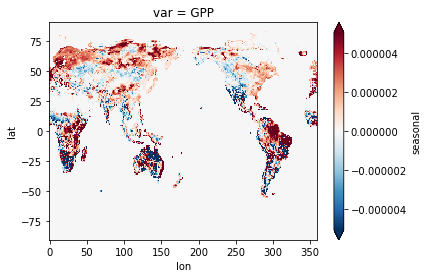

In [27]:
ds_season['seasonal'] = ds_season.seasonal.transpose('var','season','year','lat','lon')
print(ds_season.isel(var=0, season=0))
ds_season.isel(var=0, season=0, year=0).get('seasonal').plot(robust=True);

In [28]:
%%time
# TODO, again more descriptive names will make the code easier to read, but for now keeping general 
# e.g. svd_gpp = calc_svd(ds_anom['GPP'])

da0 = ds_anom.get(var[0])  
svd0 = calc_svd(da0)  # GPP 
print('finished svd0, '+var[0])

# JH, When I loaded the data as you suggested in cell #2-3, the following warnings crop up.  
# Reading the data less effiently doesn't generate the errors (as curently implimented), but I'm not sure why

#warnings.simplefilter("ignore", category=RuntimeWarning) # for RuntimeWarning only
# TODO, turn warmings back on with code below? 
#warnings.resetwarnings()



# Unused now, looking at correlation with weights of GPP anomalies seasonal climate anomalies 
#da1 = ds_anom.get(var[1])  
#da2 = ds_anom.get(var[2])  
#svd1 = calc_svd(da1)  # temp
#print('finished svd1, '+var[1])
#svd2 = calc_svd(da2)  # soil moisture
#print('finished svd2, '+var[2])

/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


finished svd0, GPP
CPU times: user 2min 43s, sys: 112 ms, total: 2min 43s
Wall time: 2min 43s


In [29]:
# rearrange output & write out to scratch
def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('thetadim','lat','lon')
    out['varfrac'] = out.varfrac.transpose('thetadim','lat','lon')
    out['vectors'] = out.vectors.transpose('time', 'vectors_dim1','lat','lon')
    out['weights'] = out.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
    ds_climo['time'] = out.time  # get time coords to match
    out['climatology'] = ds_climo.get(var)
    out.to_netcdf(path='/glade/scratch/wwieder/svd/'+model[0]+'_svd_'+var+'.nc')  
    return out

#this could also be more specific for readability, using 'GPP' instead of var[0]
svd0 = transpose(svd0, var[0])   
#svd1 = transpose(svd1, var[1])   
#svd2 = transpose(svd2, var[2])  

### Correlations between vectors and climatology of GPP
example from http://xarray.pydata.org/en/stable/dask.html

(12, 192, 288)


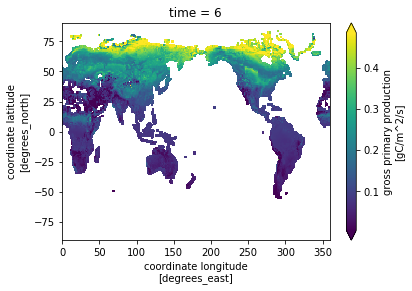

In [30]:
GPPclimo = ds_climo.GPP
GPPwgt   = GPPclimo / GPPclimo.sum(dim='time') 
print(GPPwgt.shape)
GPPwgt.isel(time=6).plot(robust=True); 

In [31]:
import bottleneck
# also try weighting correlation based on monthly contribution to annual flux
# This is code that's likely better suited for a 3rd partly library like esmlab
# TODO, file issue with requst for these kinds of statistical functions to esmlab?

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# Weighted coorelation
def covariance_gufunc_wgt(x, y, w):
    return ((w * x - (x*w).mean(axis=-1, keepdims=True))
            * (y - (y*w).mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc_wgt(x, y, w):
    return covariance_gufunc_wgt(x, y, w) / np.sqrt(
        covariance_gufunc_wgt(x, x, w) * covariance_gufunc_wgt(y,y,w))

def pearson_correlation_wgt(x, y, w, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc_wgt, x, y, w,
        input_core_dims=[[dim], [dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# rank correlation
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])


(12, 192, 288)


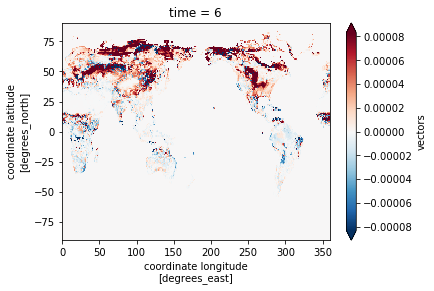

In [32]:
# subset data arrays for processing & shape correctly
print(svd0.vectors[:,0,:,:].shape)
GPPvector_0 = svd0.vectors[:,0,:,:]
GPPvector_1 = svd0.vectors[:,1,:,:]

#TBOTvector_0 = svd1.vectors[:,0,:,:]
#TBOTvector_1 = svd1.vectors[:,1,:,:]
#SMOIvector_0 = svd2.vectors[:,0,:,:]
#SMOIvector_1 = svd2.vectors[:,1,:,:]

GPPclimo['time'] =  GPPvector_0['time'] = svd0.time  # get time coords to match
GPPvector_0[6,:,:].plot(robust=True);

In [33]:
# now calculate the correlations, GPP vectors w/ GPP climatology
GPPp_0 = pearson_correlation(GPPclimo, GPPvector_0, 'time')  #GPP climatology vs. vectors
GPPp_1 = pearson_correlation(GPPclimo, GPPvector_1, 'time')  
GPPw_0 = pearson_correlation_wgt(GPPclimo, GPPvector_0, GPPwgt, 'time') 
GPPw_1 = pearson_correlation_wgt(GPPclimo, GPPvector_1, GPPwgt, 'time')
GPPr_0 = spearman_correlation(GPPclimo, GPPvector_0, 'time') 
GPPr_1 = spearman_correlation(GPPclimo, GPPvector_1, 'time')
#print(TBOTvector_0.shape)

# Rank correlation between GPP & climate
# GPP vectors vs. temp & mositure
#GPP_0_TBOT_0 = spearman_correlation(GPPvector_0, TBOTvector_0,'time') 
#GPP_0_SMOI_0 = spearman_correlation(GPPvector_0, SMOIvector_0,'time')
#GPP_0_TBOT_1 = spearman_correlation(GPPvector_0, TBOTvector_1,'time')
#GPP_0_SMOI_1 = spearman_correlation(GPPvector_0, SMOIvector_1,'time')

#GPP_1_TBOT_0 = spearman_correlation(GPPvector_1, TBOTvector_0,'time')
#GPP_1_SMOI_0 = spearman_correlation(GPPvector_1, SMOIvector_0,'time')
#GPP_1_TBOT_1 = spearman_correlation(GPPvector_1, TBOTvector_1,'time')
#GPP_1_SMOI_1 = spearman_correlation(GPPvector_1, SMOIvector_1,'time')

# Weighted correlation between GPP & climate, weighted by GPP contributions 
# Weighted GPP vectors vs. temp & mositure
#wGPP_0_TBOT_0 = pearson_correlation_wgt(GPPvector_0, TBOTvector_0,GPPwgt,'time') 
#wGPP_0_SMOI_0 = pearson_correlation_wgt(GPPvector_0, SMOIvector_0,GPPwgt,'time')
#wGPP_0_TBOT_1 = pearson_correlation_wgt(GPPvector_0, TBOTvector_1,GPPwgt,'time')
#wGPP_0_SMOI_1 = pearson_correlation_wgt(GPPvector_0, SMOIvector_1,GPPwgt,'time')

#wGPP_1_TBOT_0 = pearson_correlation_wgt(GPPvector_1, TBOTvector_0,GPPwgt,'time')
#wGPP_1_SMOI_0 = pearson_correlation_wgt(GPPvector_1, SMOIvector_0,GPPwgt,'time')
#wGPP_1_TBOT_1 = pearson_correlation_wgt(GPPvector_1, TBOTvector_1,GPPwgt,'time')
#wGPP_1_SMOI_1 = pearson_correlation_wgt(GPPvector_1, SMOIvector_1,GPPwgt,'time')

print(GPPp_0)
print()
print(xr.ufuncs.fabs(GPPr_0).max())

<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

<xarray.DataArray ()>
array(1.)


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


### Make plots to visualize results

In [34]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [35]:
# create a function to format each axes
def style_subplot(ax, title):
    ax.coastlines()
    ax.set_title(title)
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())

data_list = svd0.varfrac[0,:,:], svd0.varfrac[1,:,:]

# create the figure and subplots at the same time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,15), 
                         subplot_kws=dict(projection=ccrs.Robinson()))


for da, ax in zip(data_list, axes.flat):
    da.plot.pcolormesh('lon', 'lat', transform=ccrs.PlateCarree(),vmax=vmax, vmin=vmin, 
                       cmap='gist_earth_r', ax=ax)
    sytle_subplot(ax, da.name)
    

TypeError: __init__() got an unexpected keyword argument 'subplot_kws'

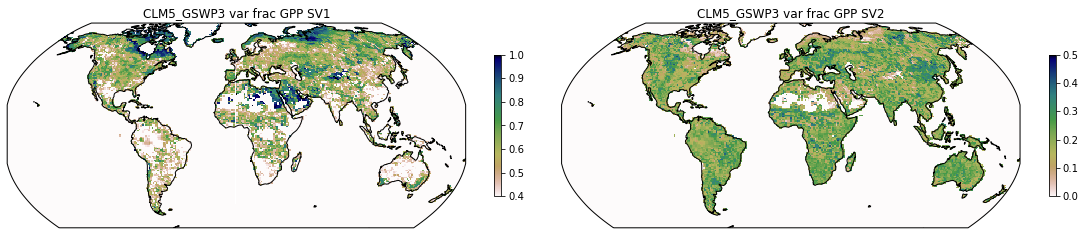

In [36]:
# just look at fraction of variance explained for each vector
# TODO is there some meaningful way to visualize information on the magnitude of each vector 
#   regionally or among models?, maybe this is with the regional plots, or as a zonal mean plot?
vmax = 1.
vmin = 0.4
lat = svd0.lat.values
lon = svd0.lon.values
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,svd0.varfrac.values[0,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.1,label='')
ax1.coastlines()
ax1.set_title(model[0]+' var frac '+var[0]+' SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())


vmax = 0.5
vmin = 0.
ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,svd0.varfrac.values[1,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.1,label='')
ax2.coastlines()
ax2.set_title(model[0]+' var frac '+var[0]+' SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout();

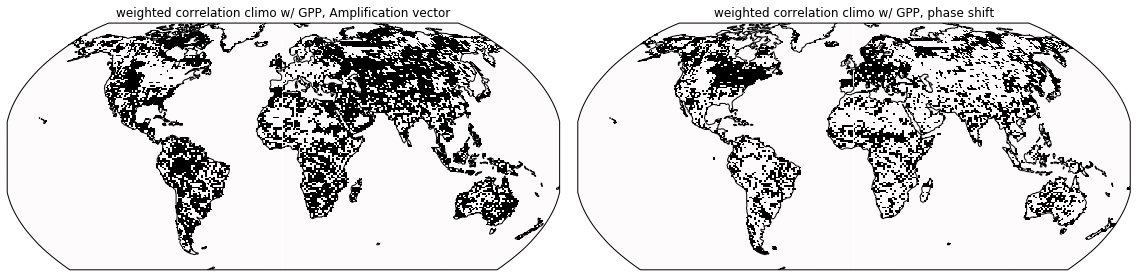

In [37]:
# Mask values to isolate regions with amplificaiton vs. phase shift (early green-up)?
GPP_climo_mask1 = xr.ufuncs.fabs(GPPw_0) >= xr.ufuncs.fabs(GPPw_1)  
GPP_climo_mask2 = xr.ufuncs.fabs(GPPw_1) > xr.ufuncs.fabs(GPPw_0)  
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,GPP_climo_mask1.values[:,:], 
                     transform=ccrs.PlateCarree(),
                     vmax=vmax,vmin=vmin,cmap='gist_earth_r')
#fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('weighted correlation climo w/ GPP, Amplification vector')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,GPP_climo_mask2.values[:,:],
                     transform=ccrs.PlateCarree(),
                     vmax=vmax,vmin=vmin,cmap='gist_earth_r')
#fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('weighted correlation climo w/ GPP, phase shift')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree());
fig.tight_layout();

### It seems like the phase shift is mostly in agricutrulal regions!

In [38]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, This may be more efficient in a loop with different lists of lat-lon regions to focus on.

a = 55  # Min lat, -20 to 10 for Amazon
b = 80  # Max lat
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 

# -- Amplitude vector --
mean_GPPclimo = GPPclimo.where(GPP_climo_mask1).sel(lat=slice(a,b), 
                                                    lon=slice(c,d)).mean(('lat','lon')) 
mean_svd0 = svd0.where(GPP_climo_mask1).sel(lat=slice(a,b), 
                                            lon=slice(c,d)).mean(('lat','lon')) 
# -- Phase shift vector -- 
mean_GPPclimoB = GPPclimo.where(GPP_climo_mask2).sel(lat=slice(a,b), 
                                                     lon=slice(c,d)).mean(('lat','lon')) 
mean_svd0B = svd0.where(GPP_climo_mask2).sel(lat=slice(a,b), 
                                             lon=slice(c,d)).mean(('lat','lon')) 

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


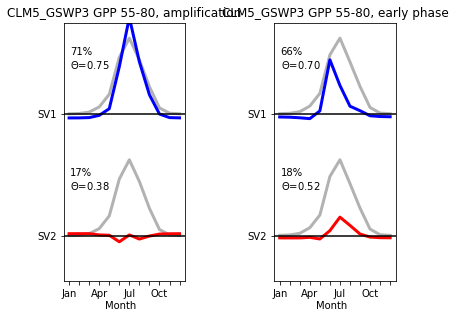

In [39]:
# Plot First and Second Singular Vectors
# TODO, but this plotting routine into a function

fig = plt.figure(4,figsize=(6,4.5))
barwidth = 0.2
month = np.arange(12)
multi =0.9e4        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd0.vectors.values)

# --- GPPP, SVD 1 & 2 for regions in phase with GPP 
vectors2plot=mean_svd0.vectors*multi  
mm2plot = mean_GPPclimo.values

ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])

ax1.text(0.5,.50,str(int(mean_svd0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0.theta[0]))
ax1.text(0.5,.10,str(int(mean_svd0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0.theta[1]))
ax1.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", amplification")
ax1.text(4,-0.29,'Month')

vectors2plot=mean_svd0B.vectors*multi  
mm2plot = mean_GPPclimoB.values
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])

ax2.text(0.5,.50,str(int(mean_svd0B.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0B.theta[0]))
ax2.text(0.5,.10,str(int(mean_svd0B.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0B.theta[1]))
ax2.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", early phase")
ax2.text(4,-0.29,'Month')

plt.tight_layout();

In [40]:
### Now look for correlations with TBOT & TWS anomalies
#GPPp_0 = pearson_correlation(GPPclimo, GPPvector_0, 'time')  #GPP climatology vs. vectors
#GPPp_1 = pearson_correlation(GPPclimo, GPPvector_1, 'time')  
# rename dimensions of weights (dim1 = vector#, dim2 = year)
svd0 = svd0.rename_dims({'weights_dim1': 'sv', 'weights_dim2': 'year'})



/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    var      <U3 'GPP'


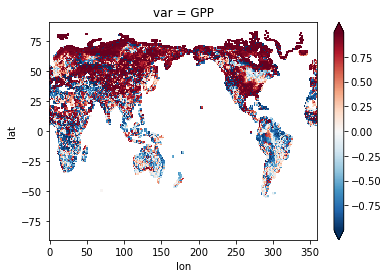

In [41]:
# Results seems sensible, GPP SV1 weights correlates with JJA anomalies in NH
sv1_gpp = pearson_correlation(ds_season['seasonal'].isel(var=0,season=2), 
                              svd0['weights'].isel(sv=0), 'year')  
sv1_gpp.plot(robust=True);
print(sv1_gpp)

In [103]:
def corr_wrap(anom, svd):
    # write out correlation matrix for weights of GPP SV_1 & SV_2
    # with detrended anomalies of var (GPP, TBOT & TWS)
    # for each season, lat & lon
    da = anom.to_array() 
    dims = dict(zip(da.dims, da.shape))
    corr_shape = (2, dims['var'],dims['season'], dims['lat'], dims['lon'])
    # setup output variables
    corr = xr.Dataset( coords={'sv': range(2),'var': var, 'season':range(4), "lat": ds.lat, "lon": ds.lon} )
    varnames = ['coef']
    corr['coef'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','var','season','lat', 'lon'))
    for h in range(2):
        for i in range(3):
            for j in range(1):
                return_vals = pearson_correlation(anom['seasonal'].isel(var=i,season=j), 
                                                  svd['weights'].isel(sv=h), 'year')
                corr['coef'][h,i,j, ...] = return_vals
        
    return corr

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Frozen(SortedKeysDict({'lat': 192, 'lon': 288, 'season': 4, 'sv': 2, 'var': 3}))


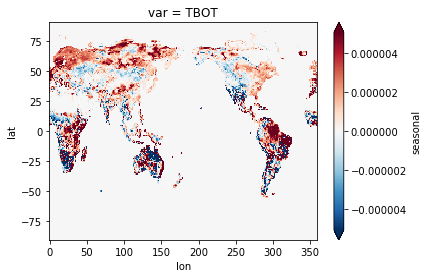

In [113]:
sv_corr = corr_wrap(ds_season, svd0)
print(sv_corr.dims)    
sv_corr['coef'].isel(sv=0,var=0, season=0).plot(robust=True);

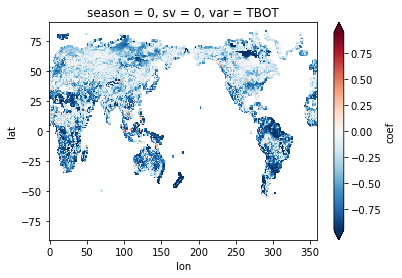

In [107]:
sv_corr['coef'].isel(sv=0,var=0, season=0).plot(robust=True);
#sv_corr['coef'].isel(sv=0,var=2, season=1).plot(robust=True);

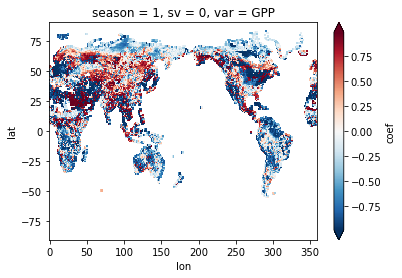

In [100]:
sv_corr['coef'].isel(sv=0,var=0, season=1).plot(robust=True);

### Grids characterized by early phase GPP SV1 also have higher % varriation explianted by soil water SV

In [51]:
# create arrays for amplification and early phase vectors
# the other line of code selects when SV2 characterizes the same shape vector
ampGPPvectors = svd0.vectors.sel(vectors_dim1=0).where(GPP_climo_mask1)
#                                                       other= svd0.vectors.sel(vectors_dim1=1))
phaseGPPvectors = svd0.vectors.sel(vectors_dim1=0).where(GPP_climo_mask2)
#                                                         other = svd0.vectors.sel(vectors_dim1=1))
  
# Weighted correlation between amplification vs. early phase vectors & climate, 
ampGPP_TBOT_0 = pearson_correlation_wgt(ampGPPvectors, TBOTvector_0,GPPwgt,'time') 
ampGPP_TBOT_1 = pearson_correlation_wgt(ampGPPvectors, TBOTvector_1,GPPwgt,'time')
ampGPP_SMOI_0 = pearson_correlation_wgt(ampGPPvectors, SMOIvector_0,GPPwgt,'time')
ampGPP_SMOI_1 = pearson_correlation_wgt(ampGPPvectors, SMOIvector_1,GPPwgt,'time')
ampGPP_TBOT_0.name ='ampGPP_TBOT_0'  # Provide name for variable to join dataset
ampGPP_TBOT_1.name ='ampGPP_TBOT_1'
ampGPP_SMOI_0.name ='ampGPP_SMOI_0'
ampGPP_SMOI_1.name ='ampGPP_SMOI_1'

phaseGPP_TBOT_0 = pearson_correlation_wgt(phaseGPPvectors, TBOTvector_0,GPPwgt,'time')
phaseGPP_TBOT_1 = pearson_correlation_wgt(phaseGPPvectors, TBOTvector_1,GPPwgt,'time')
phaseGPP_SMOI_0 = pearson_correlation_wgt(phaseGPPvectors, SMOIvector_0,GPPwgt,'time')
phaseGPP_SMOI_1 = pearson_correlation_wgt(phaseGPPvectors, SMOIvector_1,GPPwgt,'time')
phaseGPP_TBOT_0.name ='phaseGPP_TBOT_0'
phaseGPP_TBOT_1.name ='phaseGPP_TBOT_1'
phaseGPP_SMOI_0.name ='phaseGPP_SMOI_0'
phaseGPP_SMOI_1.name ='phaseGPP_SMOI_1'

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


In [52]:
# plot correlations with soil moisture & Temp
# this is for grid cells with SV1 showing amplification signial
# in cell above using the 'other' filter would allow us to look at all grid cells
# For clarity, it may be best to just show single plot with max correlations (Temp vs. Moisture)
ampGPP = xr.concat([ampGPP_SMOI_0,ampGPP_SMOI_1,ampGPP_TBOT_1,ampGPP_TBOT_0], dim='correlation')
#print(ampGPP)
phaseGPP = xr.concat([phaseGPP_SMOI_0,phaseGPP_SMOI_1,phaseGPP_TBOT_1,phaseGPP_TBOT_0], dim='correlation')
#print(ampGPP)

# argmax picks the index of the largest value across a dimension.
# 0 & 1 = soil moisture SV 1 & 2
# 2 & 3 = temperature SV 2 & 1
# The use of this mask seem to modify the look of plots, this one seems best
ampMask = ampGPP[1,:,:]
phaseMask = phaseGPP[1,:,:]

maxAmpGPP = xr.ufuncs.fabs(ampGPP).fillna(-1).argmax(dim='correlation').where(ampMask.notnull())
maxPhaseGPP = xr.ufuncs.fabs(phaseGPP).fillna(-1).argmax(dim='correlation').where(phaseMask.notnull())
#maxPhaseGPP.plot(robust=True);


<xarray.DataArray 'ampGPP_SMOI_0' ()>
array(1.94250132)
<xarray.DataArray 'phaseGPP_SMOI_0' ()>
array(1.65897048)


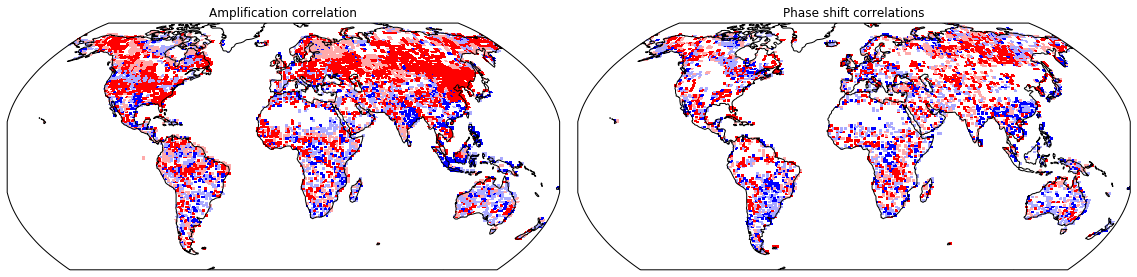

In [53]:
# vmax here just set to visually provide 
# red (temp) vs. blue (moisture) corrleations 

fig = plt.figure(figsize=(16,20))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,maxAmpGPP,
                     transform=ccrs.PlateCarree(),vmax=3,vmin=0,cmap='bwr')
#fig.colorbar(im1,ax=ax1,shrink=0.01,label='')
ax1.coastlines()
ax1.set_title('Amplification correlation')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,maxPhaseGPP,
                     transform=ccrs.PlateCarree(),vmax=3,vmin=0,cmap='bwr')
#fig.colorbar(im2,ax=ax2,shrink=0.01,label='')
ax2.coastlines()
ax2.set_title('Phase shift correlations')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout();
print(maxAmpGPP.mean())
print(maxPhaseGPP.mean())

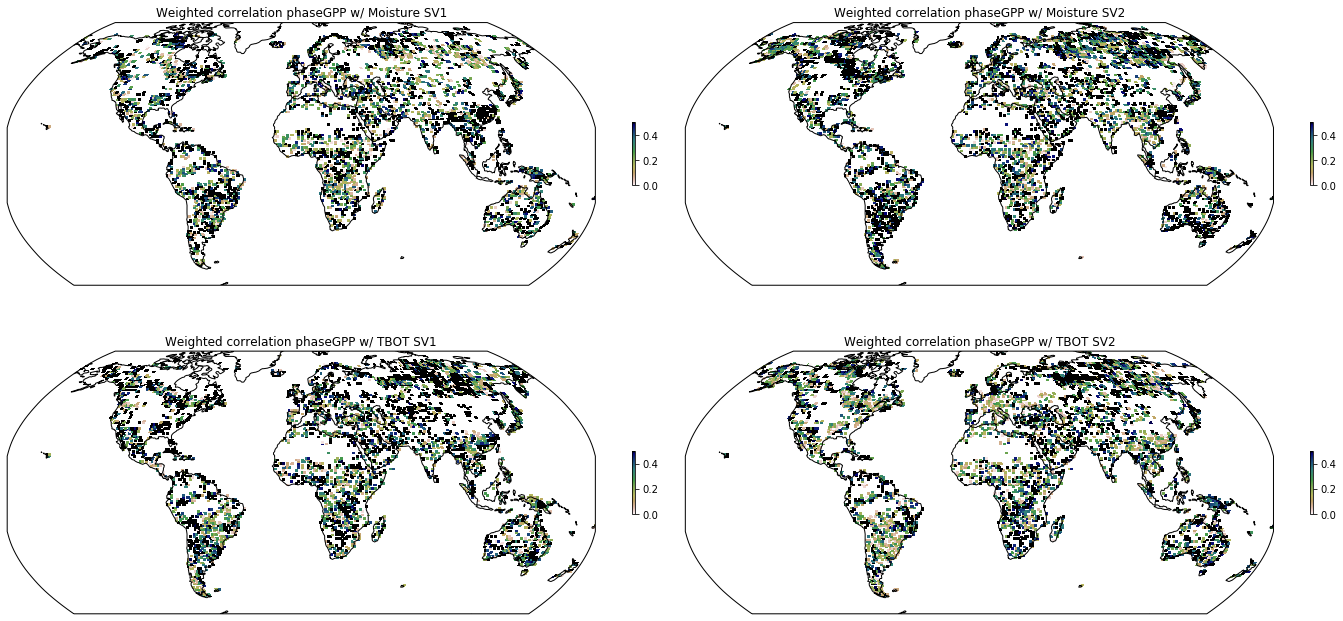

In [54]:
# plot correlations with soil moisture & Temp
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_SMOI_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.17,label='')
ax1.coastlines()
ax1.set_title('Weighted correlation phaseGPP w/ Moisture SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(2,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_SMOI_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.17,label='')
ax2.coastlines()
ax2.set_title('Weighted correlation phaseGPP w/ Moisture SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

ax3 = fig.add_subplot(2,2,3,projection=ccrs.Robinson())
im3 = ax3.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_TBOT_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im3,ax=ax3,shrink=0.17,label='')
ax3.coastlines()
ax3.set_title('Weighted correlation phaseGPP w/ TBOT SV1')
ax3.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(2,2,4,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_TBOT_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im4,ax=ax4,shrink=0.17,label='')
ax4.coastlines()
ax4.set_title('Weighted correlation phaseGPP w/ TBOT SV2')
ax4.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

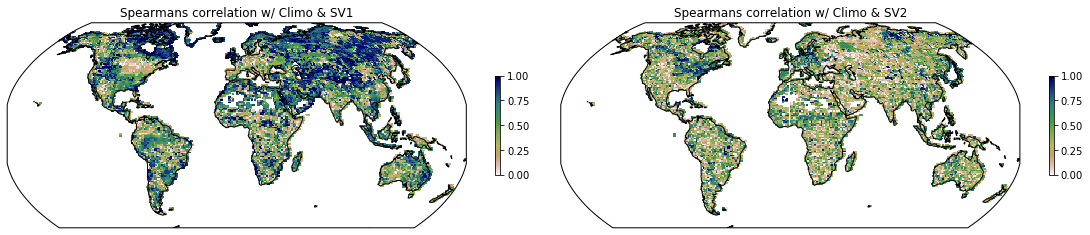

In [38]:
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPPr_0.lon.values,GPPr_0.lat.values,xr.ufuncs.fabs(GPPr_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation w/ Climo & SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPPr_1.lon.values,GPPr_1.lat.values,xr.ufuncs.fabs(GPPr_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation w/ Climo & SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()



TypeError: Dimensions of C (25, 192) are incompatible with X (288) and/or Y (192); see help(pcolormesh)

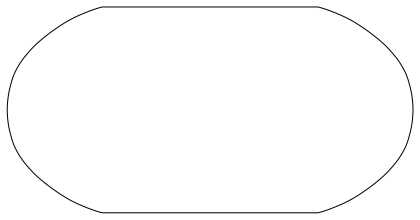

In [39]:
vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,0],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('$\Theta$ SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,1],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('$\Theta$ SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


<Figure size 360x252 with 0 Axes>

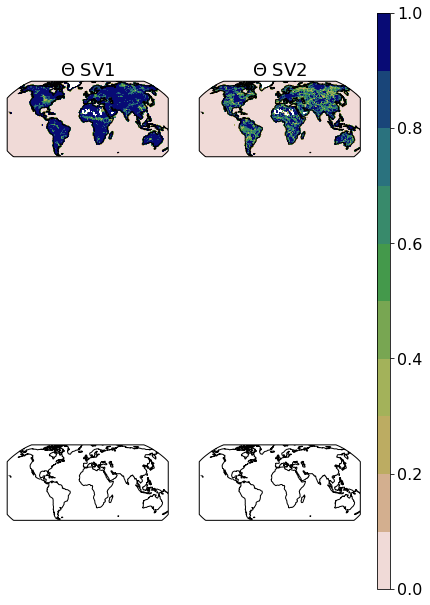

In [72]:
lat = svd2.coords['lat']
lon = svd2.coords['lon']
x0 = svd0.theta[:,:,0]
x1 = svd0.theta[:,:,1]

norm = colors.Normalize(vmin=0, vmax=1.)

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 1, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(6, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x0, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('$\Theta$ SV1', fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('$\Theta$ SV2', fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
#ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();
